# HelloPaddle01-从头搭建图像识别模型教程（CIFAR10为例）

## 一、图像识别、Cifar-10、PaddlePaddle 简介

### 1.1 图像识别

计算机视觉领域最基础也是最简单的一项任务，目的就是识别一张图中的目标属于什么种类。

### 1.2 Cifar-10 数据集

Cifar-10 数据集，一个小型的公开的图像分类的数据集，是从一个数量较多的无标注的数据集 TinyImage（小图） 标注而来，共分为10类，下图可以直观的看到图像和种类：
![avatar](https://images2018.cnblogs.com/blog/1196151/201712/1196151-20171225161744462-2083152737.png)

既然是从 TinyImage 而来，Cifar 数据集的图像尺寸是比较小的，高宽的尺寸为 32x32。从上图中也可以看出来，有些图肉眼已经很难分辨是什么。但是今天我们要让程序自己来识别每张图是什么。肉眼不易识别的图片通过程序来识别，听起来还是挺酷的。但是实现起来很简单，原理也通俗易懂，只要你对数学有一定的了解、会一些 Python 的编程基础，跟着我一步步编写和运行就可以实现了。

继续说 Cifar-10 数据集，整个数据集分为训练集和测试集：
1. 训练集 50000 张图，每类 10000 张
2. 测试集 10000张图，每类1000张

[Python版本数据点击下载](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) 来下载，下载好了解压，在数据文件夹 cifar-10-batches-py 可以看到训练集分为 5 个批次，分别为 data_batch[1-5]，详细的信息可以通过 readme.html 来看到。

### 1.3 PaddlePaddle

百度研发并开源的一个深度学习框架，我上手后使用的整体感觉较 TensorFlow 好用、方便一些。但上手难度要高于 PyTorch。
在官方介绍中 Paddle 对于大规模工业生产、大数据集环境具有较大优势。由于我们本系列的教程主要以上手 Paddle 为主，而且本机环境也不是多机多卡的环境，所以还没体验过大规模多机多卡的并行训练，就不再着重介绍这一块了。

在百度近些年的积累和开发迭代 Paddle的进程中， Paddle在各个人工智能方向提供的预训练资源相对比较丰富。尤其是 NLP 领域，其中ERNIE 在中文 NLP 各项任务中更是超越Google 1 8年网红模型 BERT，具体信息可以去 [Paddle 官方仓库](https://github.com/PaddlePaddle/models) 查看。

Paddle 文档全面清晰，同时对新手还有一定的福利 —— “PaddlePaddle 用户可领取免费 Tesla V100 在线算力资源、高效训练模型，每日登陆即送 12 小时，连续 5 天运行再加送 48小时。”对于刚进入深度学习没有 GPU 资源的同学来说，可以说是十分人性化了。我出机器让你用 Paddle 也是看到了百度要把 Paddle 做好的决心。

**总的来说 PaddlePaddle 作为百度官方主推和维护的深度学习框架，在项目维护、资源更新、框架升级等方面具有强大的保障。**在此基础上 Paddle 在易用上、工业生产上、用户量等方面一定会更上一层楼。那么就让我们“笨鸟先飞”，跟随 HelloPaddle 系列教程，体验下 Paddle 的魅力吧！

OK.下面我们开始进入正题，使用Paddle搭建一个深度学习模型来实现图像分类。<p> 图像分类一直是人工智能和模型识别领域重要的一项任务，那么该如何让机器自己能图像分类呢？<p> 首先，我们需要对数字图像有一定的了解，数字图像本质上是由大量数字组成的像素矩阵，比如我们上面说的Cifar-10的每张图其实对机器来说便是一个(32,32,3)的矩阵，这个矩阵中并非所有数字都对机器有用，存在大量的冗余，那么我们可以对这个矩阵进行抽取关键信息，假设我们这是一个简单的分类任务，分类所需的变换只是线性的，即 <code>*y=a1*x1+a2*x2..+b*</code>，这里的x1，x2..是我们抽取的关键信息，而对于同一类图像，我们认为抽取到的关键信息是相似的，不同类的图像抽取的信息是不同的，极端一点，我们假设同一类图像抽取的关键信息都是相同的，那么对于同一映射关系<code>*y=a1*x1+a2*x2..+b*</code>，**同一类的图得到的结果是相同的，不同类的图得到的结果是不同的**，由此，机器便可以通过一个函数得到分类的结果。<p> 从本质上来说，图像分类的原理就是如此简单，只不过关键信息提取不像我们说的这么简单，函数也并不是线性的变换关系而是更复杂，但是这并不妨碍我们这样理解。

接下来，我们进入实战，首先导入我们所需的一些python包：

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import os
import paddle.fluid as fluid
import paddle
import sys
from PIL import Image

接下来，我们定义刚刚下载并解压的Cifar-10的目录路径：

In [19]:
data_dir = '/home/meteo/xibin.yue/paddle/data/cifar-10-batches-py'

接下来，要多说几句了，对于一个深度学习模型的实现，大概可以分为几个步骤：
1.准备数据并对数据做一些预处理，写一个可以将数据传入模型的模块，一般情况下各个框架都封装了数据加载以及预处理模块，Paddle也有，但我们今天要自己写一个数据加载模块来加深理解。
2.搭建模型，各个框架也有现成的各种模型和预训练参数 
3.定义优化目标函数，通常在机器学习里叫做“损失函数” 
4.定义优化器 
5.训练和应用

首先是数据加载模块：Paddle中定义了几种数据读取方式，最基础的为reader，在reader之上,Paddle封装了reader creator和reader decorator。reader creator给我们返回一个reader，reader decorator可以组合多个reader，这个功能在做数据或者特征组合的时候应该很有用，后面如果用到会讲到。重点在这个reader，Paddle的reader本质上是一个迭代器，使用yield实现，python的yield不是特别了解的可以去看一下，我基本理解为是一个迭代的return。<p>接下来我们来定义一个CifarDataReader，它本质上类似于Paddle的reader creator。

## 数据加载模块

In [25]:
class CifarDataReader(object):
    """Cifar-10 Data Reader. 
    Provide a reader to read cifar 10 data iterable.

    Attributes:
        root_dir: root dir for cifar-10 data
        data_property: data for train or for validation or test
        cycle: if return data cyclic
    """

    def __init__(self, root_dir, data_property='train', cycle=True): 
        self.root_dir = root_dir
        self.data_property = data_property
        self.cycle = cycle

    def _load_cifar(self, data_path):
        try:
            data_dict = pickle.load(open(data_path, 'rb'))  # cifar python data 是二进制格式，可以用pickle加载
            raw_data = data_dict['data']
            label_data = data_dict['labels']
            batch_anno = data_dict['batch_label']
            raw_data = raw_data.reshape(10000,3,32,32).astype(np.float32) / 255.
            return raw_data, label_data, batch_anno
        except Exception as e:
            print e

    def reader(self):
        while True:
            if self.data_property == 'train':
                for batch_id in range(1, 6):   # 训练集共5个批次
                    file_path = os.path.join(self.root_dir, 'data_batch_%d' % batch_id)
                    raw_data, label_data, batch_anno = self._load_cifar(file_path)
#                     print 'BATCH INFO - %s' % batch_anno.upper()
                    length = raw_data.shape[0]
                    for i in range(length):
                        yield raw_data[i], label_data[i]
                if not self.cycle:   #如果不使用cycle 读完一遍跳出
                    break
            else:
                file_path = os.path.join(self.root_dir, 'test_batch')
                print file_path
                raw_data, label_data, batch_anno = self._load_cifar(file_path)
#                 print 'BATCH INFO - %s' % batch_anno.upper()
                length = raw_data.shape[0]
                for i in range(length):
                    yield raw_data[i], label_data[i]
                if not self.cycle:
                    break

下面我们其实可以测试一下我们定义的CifarDataReader：

(32, 32)


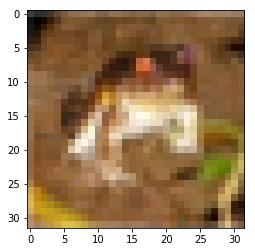

In [28]:
demo_reader = CifarDataReader('/home/meteo/xibin.yue/paddle/data/cifar-10-batches-py',cycle=False)

for item in demo_reader.reader():
    img = (item[0]* 255).transpose(1,2,0).astype(np.uint8)
    im = Image.fromarray(img)
    im.save('test_cv_channel.png') # 存一张备用
    print im.size
    plt.imshow(im)
    plt.show()
    break

可以看到，可以成功迭代的获取到数据，你能看出这是张青蛙么[汗]。但是这里感觉需要讲下图像的通道顺序问题，由于cifar-10原始数据是以二进制数据存储，我们读进来直接进行了reshape，**这里的reshape之后的通道顺序其实为RGB**，所以我们在训练的过程中其实是按照RGB的顺序训练的，这一点与Caffe不同，caffe的用户这里需要注意一下，因为caffe底层其实是用的cv2，cv2加载图像的通道顺序为BGR，而PIL的Image库中直接open的图像的顺序为RGB，因此在训练好模型之后进行inference的时候，如果用到cv2进行图像加载，需要将BGR转化为RGB，而如果用Image读取的话，不需要这一步操作。<p>下面展示了Image和cv2读取图像的不同之处：

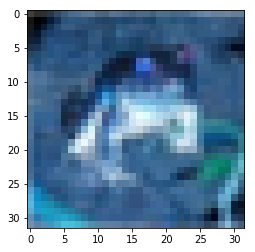

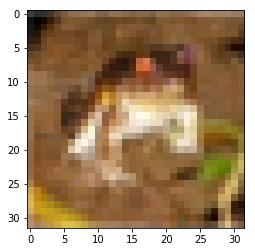

In [27]:
img = cv2.imread('test_cv_channel.png')
im = Image.fromarray(img)
plt.imshow(im)
plt.show()

im2 = Image.open('test_cv_channel.png')
plt.imshow(im2)
plt.show()

接下来我们用Paddle定义一个卷积神级网络，卷积神经网络-Convolutional Neural Network，本质上是我们上面说的信息抽取模块，最早由两位生物学家提出，是一种一定意义上具有仿生学机理的网络，最初被用在视觉上，目前在语音以及NLP领域均有应用。卷积的概念也很早，在没有深度学习之前，做图像处理用到的各种算子、滤波器很多都是卷积操作。自Lecun提出Lenet之后，以及Hinton提出逐层初始化和训练，伴随着GPU和数据量的发展，深度学习飞速发展，因此也引领了这一波人工智能智能的浪潮。<p>
卷积神经网络在前几年得到了长足的发展，包括网络结构的不断迭代优化、训练方法的优化、各种训练技巧等等，这里不再深入细讲了，讲起来就太多了。

在图像识别领域，由于早年ILSVRC比赛中ImageNet数据集，吸引了一批又一批的人提出了一个又一个经典的网络模型，如AlexNet、VGG、GoogleNet、ResNet、Densenet等等，识别准确率也一再被刷新。

今天我们用Paddle自己搭一个简单的网络，基本会用到卷积神经网络的主要操作，包括卷积、Pooling、Batch Noramlization、Dropout、FC、softmax等。

## 网络结构模块

In [5]:
def paddlenet(input):
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt,
            pool_size=2,
            pool_stride=2,
            conv_num_filter=[num_filter] * groups,
            conv_filter_size=3,
            conv_act='relu',
            conv_with_batchnorm=True,
            conv_batchnorm_drop_rate=dropouts,
            pool_type='max')  # 这里是Paddle官方封装的一个组合层，可以定义卷积参数，包括分组卷积、pooling参数、是否使用BN和Dropout 我们直接拿来用
    
    conv1 = conv_block(input, 32, 1, [0.3])
    conv2 = conv_block(conv1, 64, 1, [0.4]) 
    conv3 = conv_block(conv2, 128, 1, [0.4])  # 这里不分组，只许设定一个drop比例 如果用分组的话 需要设置多个
    fc1 = fluid.layers.fc(input=conv3, size=256, act=None)
    fc2 = fluid.layers.fc(input=fc1, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=10, act='softmax')
    return predict

上面我们没有用分组卷积，分组卷积或者channel之间的信息融合，大家可以去参考shufflenet以及后面的轻量化模型MobileNet等。其实分组卷积最早在AlexNet的时候就出现了，当时只是因为一块GPU无法完成训练，所以分在了两块GPU上，后面大家觉得channel之间需要进行信息共享和交换，便研究了各种分组卷积的模型。

下面是官网提供的vgg模型，大家可以作为参考。VGG模型大家也可以去网络学习一下。

In [3]:
def vgg_bn_drop(input):
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt,
            pool_size=2,
            pool_stride=2,
            conv_num_filter=[num_filter] * groups,
            conv_filter_size=3,
            conv_act='relu',
            conv_with_batchnorm=True,
            conv_batchnorm_drop_rate=dropouts,
            pool_type='max')

    conv1 = conv_block(input, 64, 2, [0.3, 0])
    conv2 = conv_block(conv1, 128, 2, [0.4, 0])
    conv3 = conv_block(conv2, 256, 3, [0.4, 0.4, 0])
    conv4 = conv_block(conv3, 512, 3, [0.4, 0.4, 0])
    conv5 = conv_block(conv4, 512, 3, [0.4, 0.4, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.5)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=10, act='softmax')
    return predict

定义好了网络模型，我们定义一个前馈过程得到网络输出结果：

In [29]:
def inference_network():
    data_shape = [3, 32, 32]  #顺序为C-H-W
    images = fluid.layers.data(name='pixel', shape=data_shape, dtype='float32')
    predict = paddlenet(images)
    return predict

然后定义我们的优化目标，一般分类任务的优化目标都为最小化交叉熵损失（交叉熵损失不熟的同学，需要自行去了解），下面是代码：

In [7]:
def train_network(predict):
    label = fluid.layers.data(name='label', shape=[1], dtype='int64')
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    accuracy = fluid.layers.accuracy(input=predict, label=label)
    return [avg_cost, accuracy]

接下来，我们定义优化器，包括优化方式、学习率、权重衰减等参数，Paddle官方给的是Adam方式，同时官网支持很多其他的方式，如Adadelta等，具体可以在[Paddle优化方式](https://www.paddlepaddle.org.cn/documentation/docs/zh/1.5/api_cn/optimizer_cn.html#sgd)查看。个人常用SGD，包含一些正则化项（weight decay），Paddle里面也支持加入一些正则化项，这里就不加了，优化器定义如下：

In [8]:
def optimizer_program():
    return fluid.optimizer.SGD(learning_rate=0.01)

至此，我们的数据加载模块、模型、目标函数、优化器均已定义好，下面需要将他们串在一起，就可以训练了。

首先，我们定义使用GPU还是CPU，Paddle里这个变量基本都被命名为Place，意思大概是在哪里训练吧，但总感觉不如device更契合

In [9]:
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
BATCH_SIZE = 128

下面我们来生成训练和测试用的data reader对象：

In [10]:
train_cifar = CifarDataReader('/home/meteo/xibin.yue/paddle/data/cifar-10-batches-py',cycle=False)
test_cifar = CifarDataReader('/home/meteo/xibin.yue/paddle/data/cifar-10-batches-py',data_property='test',cycle=False)

# 这里的paddle.batch和paddle.reader.shuffle是在reader上层包装了一下 batch返回一批数据 shuffle是随机顺序
train_reader = paddle.batch(paddle.reader.shuffle(train_cifar.reader,buf_size=10000),batch_size = BATCH_SIZE)
test_reader = paddle.batch(test_cifar.reader,batch_size = BATCH_SIZE)

In [11]:
feed_order = ['pixel', 'label']

main_program = fluid.default_main_program()
start_program = fluid.default_startup_program()  # 这里类似于TensorFlow里的Graph 具体的还没有深入看

main_program.random_seed = 90
start_program.random_seed = 90

# 前馈
predict = inference_network()
avg_cost, acc = train_network(predict)

test_program = main_program.clone(for_test=True)

optimizer = optimizer_program()
optimizer.minimize(avg_cost)

exe = fluid.Executor(place)

# 训练轮数
EPOCH_NUM = 10

In [12]:
# 这里定义一个在训练过程中测试集准确率的模块
def train_test(program, reader):
    count = 0
    feed_var_list = [program.global_block().var(var_name) for var_name in feed_order]
    feeder_test = fluid.DataFeeder(feed_list=feed_var_list, place=place)
    test_exe = fluid.Executor(place)
    accumulated = len([avg_cost, acc]) * [0]
    for tid, test_data in enumerate(reader()):
        avg_cost_np = test_exe.run(program=program,feed=feeder_test.feed(test_data),fetch_list=[avg_cost, acc])
        accumulated = [x[0] + x[1][0] for x in zip(accumulated, avg_cost_np)]
        count += 1
    return [x / count for x in accumulated]

In [30]:
# main train loop.
def train_loop():
    feed_var_list_loop = [main_program.global_block().var(var_name) for var_name in feed_order]
    feeder = fluid.DataFeeder(feed_list=feed_var_list_loop, place=place)
    exe.run(start_program)

    step = 0
    for pass_id in range(EPOCH_NUM):  # 这里的pass_id 便是epoch
        for step_id, data_train in enumerate(train_reader()):
            avg_loss_value = exe.run(main_program,feed=feeder.feed(data_train),fetch_list=[avg_cost, acc])
            if step_id % 100 == 0:
                print("\nPass %d, Batch %d, Cost %f, Acc %f" % 
                      (step_id, pass_id, avg_loss_value[0], avg_loss_value[1]))
            else:
                sys.stdout.write('.')
                sys.stdout.flush()
            step += 1

        avg_cost_test, accuracy_test = train_test(test_program, reader=test_reader)
        print('\nTest with Pass {0}, Loss {1:2.2}, Acc {2:2.2}'.format(pass_id, avg_cost_test, accuracy_test))

        
        fluid.io.save_inference_model('../weights', ["pixel"],[predict], exe) # 保存参数

        if pass_id == EPOCH_NUM - 1:
            print("kpis\ttrain_cost\t%f" % avg_loss_value[0])
            print("kpis\ttrain_acc\t%f" % avg_loss_value[1])
            print("kpis\ttest_cost\t%f" % avg_cost_test)
            print("kpis\ttest_acc\t%f" % accuracy_test)

上述训练过程基本都是按照官网b

In [ ]:
train_loop()

In [16]:
def infer(use_cuda, params_dirname=None):
    from PIL import Image
    place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
    exe = fluid.Executor(place)
    inference_scope = fluid.core.Scope()

    def load_image(infer_file):
        im = Image.open(infer_file)
        im = im.resize((32, 32), Image.ANTIALIAS)

        im = numpy.array(im).astype(numpy.float32)
        im = im.transpose((2, 0, 1))  # CHW
        im = im / 255.0
        im = numpy.expand_dims(im, axis=0)
        return im

    cur_dir = os.path.dirname(os.path.realpath(__file__))
    img = load_image(cur_dir + '/image/dog.png')

    with fluid.scope_guard(inference_scope):
        [inference_program, feed_target_names,
         fetch_targets] = fluid.io.load_inference_model(params_dirname, exe)
        inference_transpiler_program = inference_program.clone()
        t = fluid.transpiler.InferenceTranspiler()
        t.transpile(inference_transpiler_program, place)
        results = exe.run(
            inference_program,
            feed={feed_target_names[0]: img},
            fetch_list=fetch_targets)

        transpiler_results = exe.run(
            inference_transpiler_program,
            feed={feed_target_names[0]: img},
            fetch_list=fetch_targets)

        assert len(results[0]) == len(transpiler_results[0])
        for i in range(len(results[0])):
            numpy.testing.assert_almost_equal(
                results[0][i], transpiler_results[0][i], decimal=5)

        # infer label
        label_list = [
            "airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
            "horse", "ship", "truck"
        ]

        print("infer results: %s" % label_list[numpy.argmax(results[0])])